In [17]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import normalize, to_categorical
from keras.preprocessing import image
from keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from prettytable import PrettyTable

In [18]:
rootPath = './spectrograms2/All/'
imgPath = 'train/clean/'
testImgPath = rootPath + imgPath + os.listdir(rootPath + imgPath)[0]
res = [cv2.imread(testImgPath).shape[0], cv2.imread(testImgPath).shape[1]]

print('Current Resolution: \t' + str(res))

#res = [int(res[0]/2), int(res[1]/2)]
#print('New Resolution: \t' + str(res))

#res = [int(res[0]/1.5), int(res[1]/1.5)]
#print('New Resolution: \t' + str(res))

res = [int(res[0]/4), int(res[1]/4)]
print('New Resolution: \t' + str(res))

Current Resolution: 	[540, 1080]
New Resolution: 	[135, 270]


In [19]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

In [20]:
train_dataset = train.flow_from_directory(
    rootPath + 'train/',
    target_size = (res[0], res[1]),
    batch_size = 10,
    class_mode = 'binary'
)

validation_dataset = validation.flow_from_directory(
    rootPath + 'validate/',
    target_size = (res[0], res[1]),
    batch_size = 10,
    class_mode = 'binary'
)

Found 240 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [21]:
#print(train_dataset.class_indices)
#print(validation_dataset.class_indices)

# train generator (rotate images)

train_datagen = ImageDataGenerator(rotation_range=45,
    width_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip = True)
train_datagen.fit(train_dataset)

train_generator = train_datagen.flow(
    train_dataset,
    batch_size = 32)

In [22]:
# old model
activation = 'relu'
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation=activation, input_shape=(res[0], res[1], 3)),
    tf.keras.layers.MaxPool2D(2,2),
    #
    tf.keras.layers.Conv2D(32,(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    #
    tf.keras.layers.Conv2D(64,(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    #
    tf.keras.layers.Conv2D(64,(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    ##
    tf.keras.layers.Flatten(),
    ##
    tf.keras.layers.Dense(512, activation=activation),
    ##
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

activation = 'sigmoid'
model = Sequential()
model.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (res[0], res[1], 3)))
model.add(BatchNormalization())

model.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation = activation, kernel_initializer = 'he_uniform'))
model.add(Dense(1, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())

In [23]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=0.001),
    metrics=['accuracy']
)

In [24]:
model_fit = model.fit(
    train_dataset,
    steps_per_epoch=24,
    epochs=100,
    validation_data=validation_dataset
)

Epoch 1/50
24/24 [==============================] - 8s 311ms/step - loss: 1.0051 - accuracy: 0.5920 - val_loss: 0.3595 - val_accuracy: 0.8667
Epoch 2/50
24/24 [==============================] - 8s 310ms/step - loss: 0.3268 - accuracy: 0.8739 - val_loss: 0.2138 - val_accuracy: 0.9333
Epoch 3/50
24/24 [==============================] - 7s 301ms/step - loss: 0.1403 - accuracy: 0.9624 - val_loss: 0.3066 - val_accuracy: 0.9000
Epoch 4/50
24/24 [==============================] - 7s 292ms/step - loss: 0.3322 - accuracy: 0.8859 - val_loss: 0.2366 - val_accuracy: 0.9000
Epoch 5/50
24/24 [==============================] - 7s 305ms/step - loss: 0.1242 - accuracy: 0.9621 - val_loss: 0.3707 - val_accuracy: 0.9333
Epoch 6/50
24/24 [==============================] - 7s 291ms/step - loss: 0.0941 - accuracy: 0.9725 - val_loss: 0.2872 - val_accuracy: 0.9500
Epoch 7/50
24/24 [==============================] - 7s 289ms/step - loss: 0.0495 - accuracy: 0.9831 - val_loss: 0.3241 - val_accuracy: 0.9500
Epoch 

In [25]:
def resultStore(file, pred, results):
    pred = pred.lower() if pred != 'lead or rhythm' else 'lead' if 'lead' in file else 'rhythm'
    if pred in file:
        results[0] = 'PASS'
        results[1] = results[1] + 1
    else:
        results[0] = 'FAIL'
        results[2] = results[2] + 1
    return results

def resultStats(results):
    total = results[1] + results[2]
    p = round(results[1]*100/total, 2)
    f = round(results[2]*100/total, 2)
    return 'Pass: ' + str(p) + '% (' + str(results[1]) + '), Fail: ' + str(f) + '% (' + str(results[2]) + '), Total: ' + str(total)

In [26]:
validation_dataset.class_indices
classes = {v: k for k, v in validation_dataset.class_indices.items()}
print(classes)

{0: 'clean', 1: 'lead or rhythm'}


testPath = rootPath + 'test/'
results = ["", 0, 0]

table = PrettyTable()
table.field_names = ["1", "File", "2", "Class", "3", "Prediction", "4", "Result", " "]

for i in os.listdir(testPath):
    img = image.load_img(
        testPath + '//' + i,
        target_size = (res[0], res[1])
    )

    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    prediction = int(model.predict(images))
    
    results = resultStore(i, classes[prediction][3:-4], results)
    splt = i.split('_session_')
    clss = splt[0]
    fname = splt[1].replace('_', ' ')
    table.add_row(["", fname[:-4], "", clss, "", classes[prediction][3:-4], "", results[0], ""])

table.align = 'l'
print(table)

print('\n' + resultStats(results))

In [ ]:
def get_precision(prec, result):
    if result == "PASS":
        prec[0] = prec[0] + 1
        prec[1] = prec[1] + 1
    else:
        prec[1] = prec[1] + 1
    return prec

def get_recall(rec, result, clss):
    if clss == 0:
        if result == "PASS":
            rec[0] = rec[0] + 1
            rec[1] = rec[1] + 1
        else:
            rec[3] = rec[3] + 1
    else:
        if result == "PASS":
            rec[2] = rec[2] + 1
            rec[3] = rec[3] + 1
        else:
            rec[1] = rec[1] + 1
    return rec

def get_fscore(prec, rec):
    return 2 * ((prec * rec) / (prec + rec))

def get_metrics(precision1, precision2, recall, classes):
    precision = [round((precision1[0]/precision1[1]), 2)*100, round((precision2[0]/precision2[1]), 2)*100]
    recall = [round((recall[0]/recall[1]), 2)*100, round((recall[2]/recall[3]), 2)*100]
    fscore = [round(get_fscore(precision[0], recall[0]),2), round(get_fscore(precision[1], recall[1]),2)]

    metrics_table = PrettyTable()
    metrics_table.field_names = ["Class", "Precision", "Recall", "F-Score"]
    for i in classes:
        metrics_table.add_row([classes[i], precision[i], recall[i], fscore[i]])
    return metrics_table

In [27]:
recall = [0,0,0,0]
precision1 = [0,0]
precision2 = [0,0]
fscore = [0,0]

testPath = rootPath + 'test/'
results = ["", 0, 0]

table = PrettyTable()
table.field_names = ["File", "Class", "Prediction", "Result"]

for i in os.listdir(testPath):
    img = image.load_img(
        testPath + '//' + i,
        target_size = (res[0], res[1])
    )

    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    prediction = int(model.predict(images))
    
    results = resultStore(i, classes[prediction], results)
    splt = i.split('_session_')
    clss = splt[0]
    fname = splt[1].replace('_', ' ')
    table.add_row([fname[:-4] + "    ", clss + "    ", classes[prediction] + "    ", results[0] + "    "])

table.align = 'l'
print(table)

print('\n' + resultStats(results))

print(get_metrics(precision1, precision2, recall, classes))

+-----------------------------------+------------+--------------------+----------+
| File                              | Class      | Prediction         | Result   |
+-----------------------------------+------------+--------------------+----------+
| Audio 51                          | clean      | clean              | PASS     |
| Audio 52                          | clean      | clean              | PASS     |
| Audio 54                          | clean      | clean              | PASS     |
| Audio 55                          | clean      | clean              | PASS     |
| Audio 56                          | clean      | clean              | PASS     |
| Audio 57                          | clean      | clean              | PASS     |
| Audio 58                          | clean      | clean              | PASS     |
| Audio 59                          | clean      | clean              | PASS     |
| Audio 60                          | clean      | clean              | PASS     |
| Au

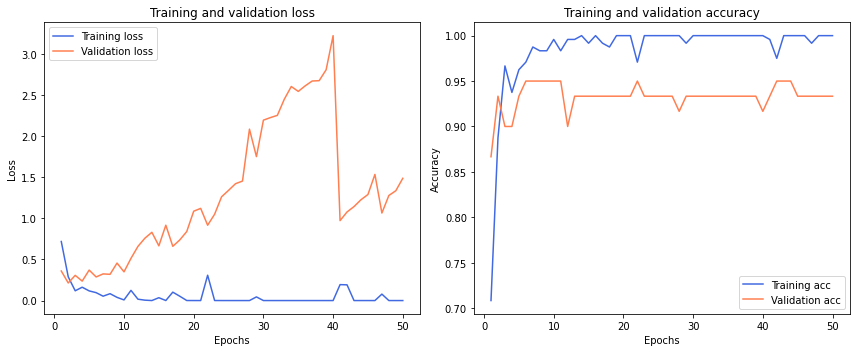

In [33]:
#plot the training and validation accuracy and loss at each epoch
plt.subplot(1, 2, 1)
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'royalblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
plt.plot(epochs, acc, 'royalblue', label='Training acc')
plt.plot(epochs, val_acc, 'coral', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.rcParams['figure.figsize'] = [12, 5]
plt.tight_layout()
plt.savefig("test.pdf", format="pdf")
plt.show()

In [29]:
# Save trained model
json_model = model.to_json()

#save the model architecture to JSON file
with open('model-clean-lr-100p.json', 'w') as json_file:
    json_file.write(json_model)

model.save('model-clean-lr-100p.h5')

In [30]:
# Do a test with loaded model

loaded_model = load_model('model-clean-lr-100p.h5')

testPath = rootPath + 'test/'
results = ["", 0, 0]

table = PrettyTable()
table.field_names = ["File", "Class", "Prediction", "Result"]

for i in os.listdir(testPath):
    img = image.load_img(
        testPath + '//' + i,
        target_size = (res[0], res[1])
    )

    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    prediction = int(loaded_model.predict(images))
    
    results = resultStore(i, classes[prediction], results)
    splt = i.split('_session_')
    clss = splt[0]
    fname = splt[1].replace('_', ' ')
    table.add_row([fname[:-4] + "    ", clss + "    ", classes[prediction], results[0] + "    "])

table.align = 'l'
print(table)

print('\n' + resultStats(results))

+-----------------------------------+------------+----------------+----------+
| File                              | Class      | Prediction     | Result   |
+-----------------------------------+------------+----------------+----------+
| Audio 51                          | clean      | clean          | PASS     |
| Audio 52                          | clean      | clean          | PASS     |
| Audio 54                          | clean      | clean          | PASS     |
| Audio 55                          | clean      | clean          | PASS     |
| Audio 56                          | clean      | clean          | PASS     |
| Audio 57                          | clean      | clean          | PASS     |
| Audio 58                          | clean      | clean          | PASS     |
| Audio 59                          | clean      | clean          | PASS     |
| Audio 60                          | clean      | clean          | PASS     |
| Audio 53                          | clean      | c